<a href="https://colab.research.google.com/github/tomektomeknyc/machinelearning/blob/main/VARMA_Econometrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U statsmodels

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 16.5 MB/s eta 0:00:00
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.13.5
    Uninstalling statsmodels-0.13.5:
      Successfully uninstalled statsmodels-0.13.5


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

In [3]:
!wget https://lazyprogrammer.me/course_files/timeseries/us_macro_quarterly.xlsx

--2023-07-20 19:27:12--  https://lazyprogrammer.me/course_files/timeseries/us_macro_quarterly.xlsx
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 76805 (75K) [application/vnd.openxmlformats-officedocument.spreadsheetml.sheet]
Saving to: ‘us_macro_quarterly.xlsx’

us_macro_quarterly. 100%[===================>]  75.00K  --.-KB/s    in 0.01s   

2023-07-20 19:27:13 (5.97 MB/s) - ‘us_macro_quarterly.xlsx’ saved [76805/76805]



In [4]:
df = pd.read_excel('us_macro_quarterly.xlsx')

/usr/local/lib/python3.10/dist-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [5]:
df.head()

,Unnamed: 0,GDPC96,JAPAN_IP,PCECTPI,GS10,GS1,TB3MS,UNRATE,EXUSUK,CPIAUCSL
0,1957:01,2851.778,8.414363,16.449,3.403333,3.390000,3.096667,3.933333,NaN,27.776667
1,1957:02,2845.453,9.097347,16.553,3.626667,3.540000,3.140000,4.100000,NaN,28.013333
2,1957:03,2873.169,9.042708,16.687,3.926667,3.963333,3.353333,4.233333,NaN,28.263333
3,1957:04,2843.718,8.796834,16.773,3.633333,3.586667,3.310000,4.933333,NaN,28.400000
4,1958:01,2770.000,8.632918,16.978,3.040000,2.160000,1.756667,6.300000,NaN,28.736667


In [6]:
def parse_date(data):
  # quarter is in {01,02,03,04}
  year, quarter = data.split(':')
  month = (int(quarter) - 1) * 3 + 1
  s = f"{year}-{month}"
  return datetime.strptime(s, "%Y-%m")

In [7]:
df['Date'] = df['Unnamed: 0'].apply(parse_date)

In [8]:
df.head()

,Unnamed: 0,GDPC96,JAPAN_IP,PCECTPI,GS10,GS1,TB3MS,UNRATE,EXUSUK,CPIAUCSL,Date
0,1957:01,2851.778,8.414363,16.449,3.403333,3.390000,3.096667,3.933333,NaN,27.776667,1957-01-01
1,1957:02,2845.453,9.097347,16.553,3.626667,3.540000,3.140000,4.100000,NaN,28.013333,1957-04-01
2,1957:03,2873.169,9.042708,16.687,3.926667,3.963333,3.353333,4.233333,NaN,28.263333,1957-07-01
3,1957:04,2843.718,8.796834,16.773,3.633333,3.586667,3.310000,4.933333,NaN,28.400000,1957-10-01
4,1958:01,2770.000,8.632918,16.978,3.040000,2.160000,1.756667,6.300000,NaN,28.736667,1958-01-01


In [9]:
df.set_index(df['Date'], inplace=True)
df.drop(['Date', 'Unnamed: 0'], axis=1, inplace=True)

In [10]:
df.index.freq = 'QS'

In [11]:
df.head()

,GDPC96,JAPAN_IP,PCECTPI,GS10,GS1,TB3MS,UNRATE,EXUSUK,CPIAUCSL
Date,,,,,,,,,
1957-01-01,2851.778,8.414363,16.449,3.403333,3.390000,3.096667,3.933333,NaN,27.776667
1957-04-01,2845.453,9.097347,16.553,3.626667,3.540000,3.140000,4.100000,NaN,28.013333
1957-07-01,2873.169,9.042708,16.687,3.926667,3.963333,3.353333,4.233333,NaN,28.263333
1957-10-01,2843.718,8.796834,16.773,3.633333,3.586667,3.310000,4.933333,NaN,28.400000
1958-01-01,2770.000,8.632918,16.978,3.040000,2.160000,1.756667,6.300000,NaN,28.736667


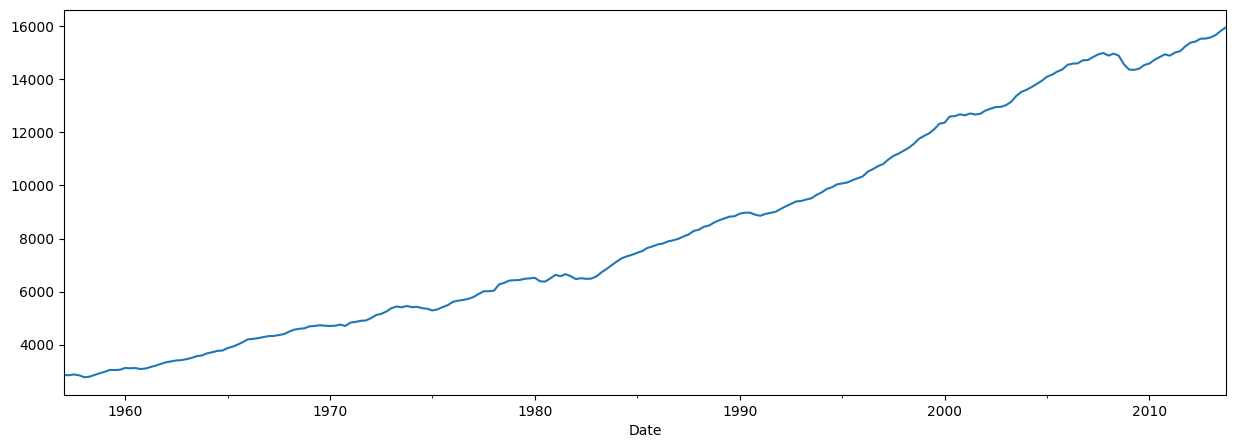

In [12]:
# GDP
df['GDPC96'].plot(figsize=(15, 5));

In [13]:
df['GDPGrowth'] = np.log(df['GDPC96']).diff()


In [14]:
df['TSpread'] = df['GS10'] - df['TB3MS']

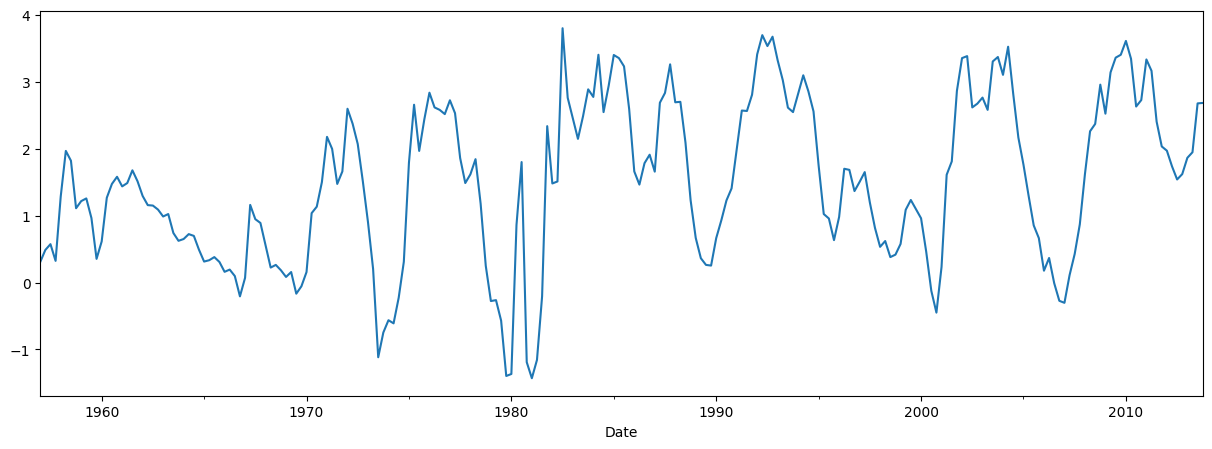

In [15]:
df['TSpread'].plot(figsize=(15, 5));

In [16]:
cols = ['GDPGrowth', 'TSpread']

In [17]:

df1 = df.iloc[1:][cols].copy()

In [18]:
Ntest = 12
train = df1.iloc[:-Ntest].copy()
test = df1.iloc[-Ntest:].copy()

In [19]:
train_idx = df1.index <= train.index[-1]
test_idx = ~train_idx

In [20]:
# just overwrite originals, unless you want to preserve them
scaler = StandardScaler()
train[cols] = scaler.fit_transform(train)
test[cols] = scaler.transform(test)

In [21]:
df1.loc[train_idx, :] = train
df1.loc[test_idx, :] = test

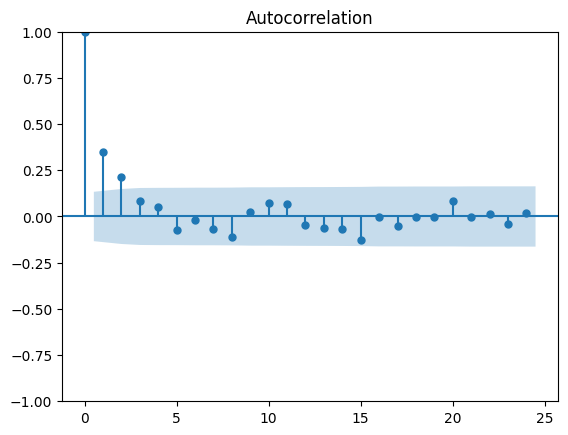

In [22]:

plot_acf(train['GDPGrowth']);

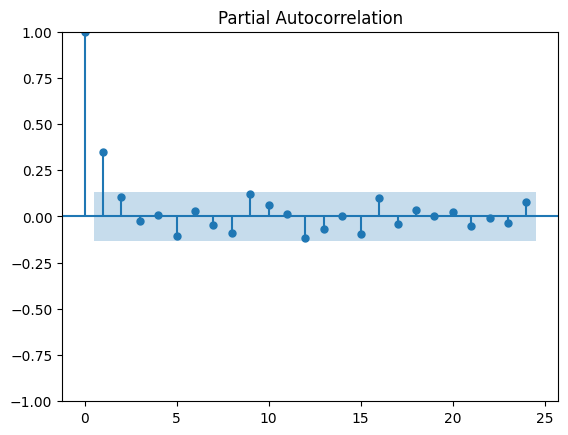

In [23]:
plot_pacf(train['GDPGrowth']);

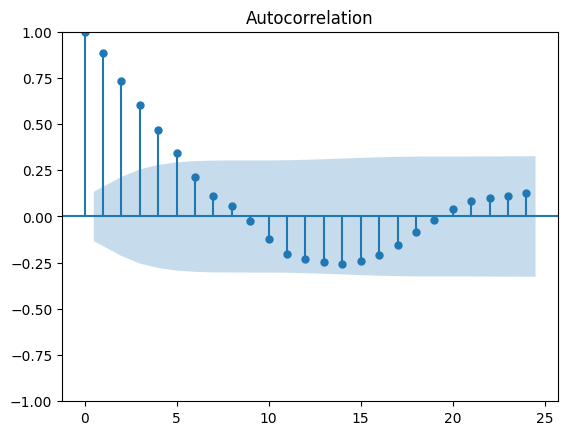

In [24]:
plot_acf(train['TSpread']);

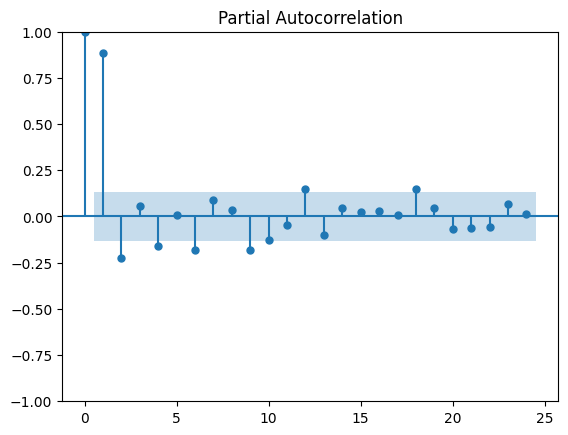

In [25]:
plot_pacf(train['TSpread']);

In [26]:
adfuller(train['GDPGrowth'])

(-7.44663965462558,
 5.814896580913866e-11,
 1,
 213,
 {'1%': -3.461429147102264,
  '5%': -2.875206950587861,
  '10%': -2.5740544497344002},
 512.854231063742)

In [27]:
adfuller(train['TSpread'])

(-4.001020795475584,
 0.001405175490749345,
 12,
 202,
 {'1%': -3.4631437906252636,
  '5%': -2.8759570379821047,
  '10%': -2.574454682874228},
 246.36949884218734)

In [28]:
p = 18
q = 1

In [29]:
t0 = datetime.now()
model = VARMAX(train, order=(p, q))
res = model.fit(maxiter=100)
print("Duration:", datetime.now() - t0)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Duration: 0:01:41.961305


In [30]:

fcast = res.get_forecast(Ntest)

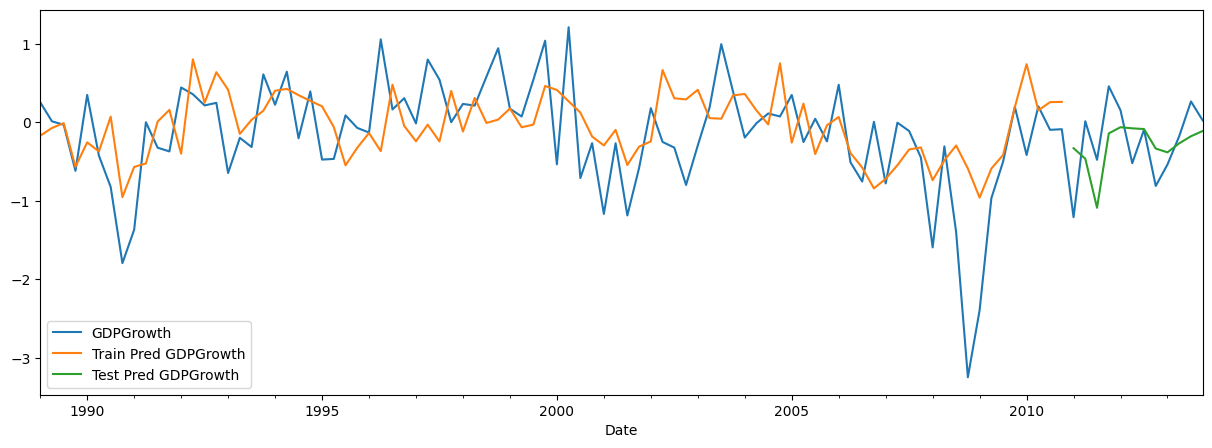

In [31]:
df1.loc[train_idx, 'Train Pred GDPGrowth'] = res.fittedvalues['GDPGrowth']
df1.loc[test_idx, 'Test Pred GDPGrowth'] = fcast.predicted_mean['GDPGrowth']
plot_cols = ['GDPGrowth', 'Train Pred GDPGrowth', 'Test Pred GDPGrowth']
df1.iloc[-100:][plot_cols].plot(figsize=(15, 5));

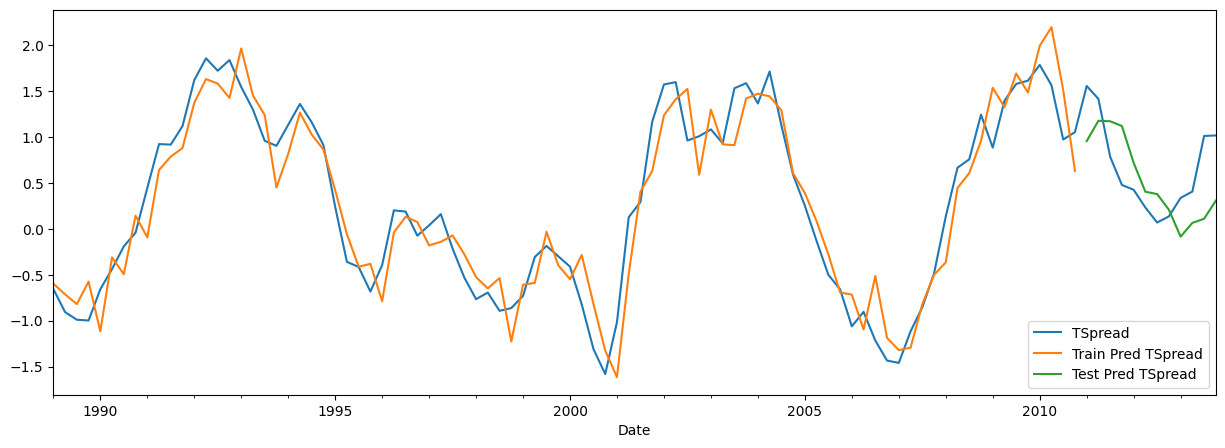

In [32]:
df1.loc[train_idx, 'Train Pred TSpread'] = res.fittedvalues['TSpread']
df1.loc[test_idx, 'Test Pred TSpread'] = fcast.predicted_mean['TSpread']
plot_cols = ['TSpread', 'Train Pred TSpread', 'Test Pred TSpread']
df1.iloc[-100:][plot_cols].plot(figsize=(15, 5));


In [33]:
for col in cols:
  y_true = df1.loc[train_idx, col]
  y_pred = res.fittedvalues[col]
  print("Train R^2:", r2_score(y_true, y_pred))

  y_true = df1.loc[test_idx, col]
  y_pred = fcast.predicted_mean[col]
  print("Test R^2:", r2_score(y_true, y_pred))

Train R^2: 0.2764525794581447
Test R^2: 0.03702139126432746
Train R^2: 0.8736922352043073
Test R^2: -0.03825890180825797


In [34]:
model = VAR(train)


In [35]:
lag_order_results = model.select_order(maxlags=20)
lag_order_results.selected_orders

{'aic': 10, 'bic': 1, 'hqic': 2, 'fpe': 10}

In [36]:
results = model.fit(maxlags=20, ic='aic')


In [37]:
lag_order = results.k_ar

In [38]:
prior = train.iloc[-lag_order:][cols].to_numpy() # why need this?
fcast = results.forecast(prior, Ntest)

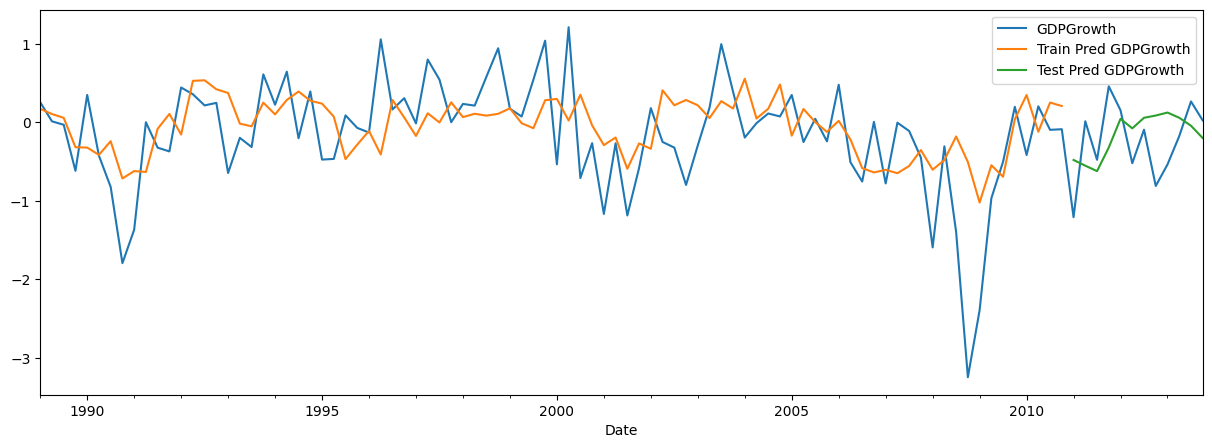

In [39]:
df1.loc[train_idx, 'Train Pred GDPGrowth'] = results.fittedvalues['GDPGrowth']
df1.loc[test_idx, 'Test Pred GDPGrowth'] = fcast[:,0]
plot_cols = ['GDPGrowth', 'Train Pred GDPGrowth', 'Test Pred GDPGrowth']
df1.iloc[-100:][plot_cols].plot(figsize=(15, 5));


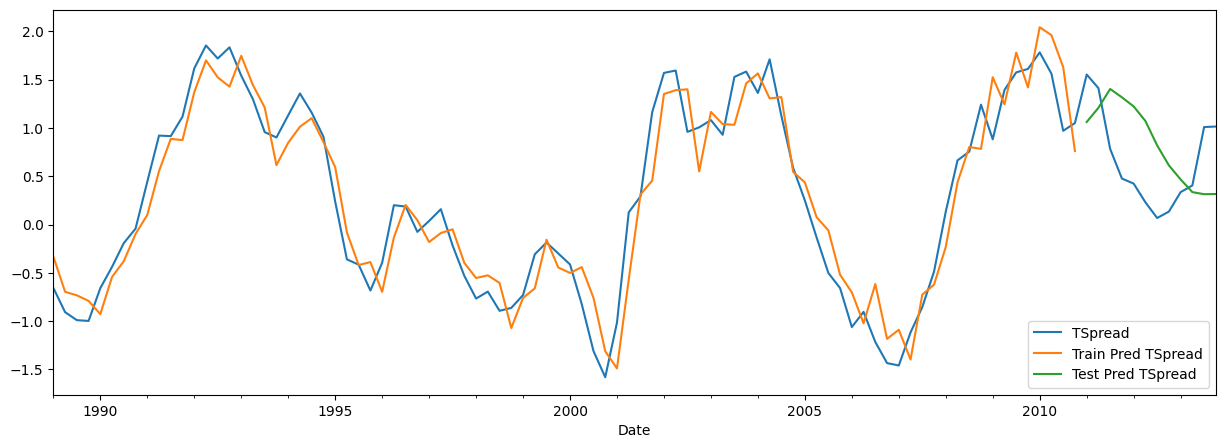

In [40]:
df1.loc[train_idx, 'Train Pred TSpread'] = results.fittedvalues['TSpread']
df1.loc[test_idx, 'Test Pred TSpread'] = fcast[:,1]
plot_cols = ['TSpread', 'Train Pred TSpread', 'Test Pred TSpread']
df1.iloc[-100:][plot_cols].plot(figsize=(15, 5));

In [41]:
y_pred = df1.loc[train_idx, 'Train Pred GDPGrowth']
y_true = df1.loc[train_idx, 'GDPGrowth']
y_true = y_true.iloc[lag_order:]
y_pred = y_pred.iloc[lag_order:]
print("GDPGrowth Train R^2:", r2_score(y_true, y_pred))

y_pred = df1.loc[test_idx, 'Test Pred GDPGrowth']
y_true = df1.loc[test_idx, 'GDPGrowth']
print("GDPGrowth Test R^2:", r2_score(y_true, y_pred))
GDPGrowth Train R^2: 0.2569812409739456
GDPGrowth Test R^2: -0.23961760567260937
y_pred = df1.loc[train_idx, 'Train Pred TSpread']
y_true = df1.loc[train_idx, 'TSpread']
y_true = y_true.iloc[lag_order:]
y_pred = y_pred.iloc[lag_order:]
print("TSpread Train R^2:", r2_score(y_true, y_pred))

y_pred = df1.loc[test_idx, 'Test Pred TSpread']
y_true = df1.loc[test_idx, 'TSpread']
print("TSpread Test R^2:", r2_score(y_true, y_pred))

SyntaxError: ignored

In [42]:
for col in cols:
  model = ARIMA(train[col], order=(p, 0, q))
  res = model.fit()
  fcast = res.get_forecast(Ntest)
  y_train = df1.loc[train_idx, col]
  y_test = df1.loc[test_idx, col]
  print(f"{col} Train R^2:", r2_score(y_train, res.fittedvalues))
  print(f"{col} Test R^2:", r2_score(y_test, fcast.predicted_mean))

GDPGrowth Train R^2: 0.20569396246142635
GDPGrowth Test R^2: -0.848648348189061
TSpread Train R^2: 0.8332486531717905
TSpread Test R^2: -2.9963834647129985
